In [129]:
import os
import re
import h5py
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle as pkl

import nltk
from nltk.corpus import stopwords
languages = ['english', 'german', 'french', 'finnish', 'swedish', 'norwegian', 'danish', 'russian']
stop_words = set()
for language in languages:
    stop_words.update(set(stopwords.words(language)))
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, confusion_matrix, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from mlxtend.classifier import StackingClassifier
from imblearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler, SMOTE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

# Preprocessing
## Combine song lyrics with genres

In [7]:
# LYRICS_DIR = 'lyrics/'
# BANDS_DIR = 'bands/'

In [8]:
# band_filenames = [f for f in os.listdir(BANDS_DIR) if '.pkl' in f]
# bands = [pkl.load(open(os.path.join(BANDS_DIR, f), 'rb')) for f in band_filenames]
# band_genres = {b.name.lower(): b.genres for b in bands}

In [9]:
# lyrics_filenames = [f for f in os.listdir(LYRICS_DIR) if '.pkl' in f]
# lyrics = {filename.replace('.pkl', ''): pkl.load(open(os.path.join(LYRICS_DIR, filename), 'rb')) for filename in lyrics_filenames}
# corpus = []
# band_names = []
# song_names = []
# vocabulary = set()
# genres = []
# for band, band_lyrics in lyrics.items():
#     if band in band_genres.keys():
#         for album, album_lyrics in band_lyrics.items():
#             for song, song_lyrics in album_lyrics.items():
#                 words = []
#                 for line in song_lyrics:
#                     for w in line.split():
#                         s = re.search("(\w+)|(\w+([-'])(\w+)?[']?(\w+))", w.lower())
#                         if s:
#                             w = s.group()
#                             if w not in stop_words:
#                                 words.append(w)
#                 song_name = []
#                 for w in song.split():
#                     s = re.search("(\w+)|(\w+([-'])(\w+)?[']?(\w+))", re.sub('\d+\.', '', w).lower())
#                     if s:
#                         song_name.append(s.group())
#                 song_name = ' '.join(song_name)
#                 document = ' '.join(words)
#                 if len(document) > 0:
#                     corpus.append(document)
#                     band_names.append(band)
#                     song_names.append(song_name)
#                     vocabulary.update(set(words))
#                     genres.append(band_genres[band])
# print("vocabulary size: {}".format(len(vocabulary)))

vocabulary size: 170519


### Full lyrics + genres dataframe

In [10]:
# df_rows = [
#     {'band': band_names[i], 'song': song_names[i], 'lyrics': corpus[i], 'genres': genres[i]} for i in range(len(corpus))
# ]
# df = pd.DataFrame(df_rows, columns=['band', 'song', 'lyrics', 'genres'])
# df = df.drop_duplicates(subset=['band', 'song'])
# print(df.shape)
# df.head()

(42460, 4)


,band,song,lyrics,genres
0,aarni,myrrys,ääni tuulen varjot puiden yksinäni uneksin hal...,"[avant-garde, doom]"
1,aarni,the black keyes of r,five hundred years gone since summoned thee le...,"[avant-garde, doom]"
2,aarni,metsänpeitto sample 1 2,metsäpolulta metsän polulle metsänpeitossa for...,"[avant-garde, doom]"
3,aarni,persona mortuae cutis,yog clavis portaque cum primis digitis cutem m...,"[avant-garde, doom]"
4,aarni,ubbo,ubbo source coming zhothaqquah yok kthulhut st...,"[avant-garde, doom]"


In [2]:
df = pd.read_hdf('combined-data/song-lyrics-genres-short.h5', key='df', mode='r')

### Statistics of song word counts

In [3]:
song_lengths = df['lyrics'].apply(lambda x: len(x.split()))
print(round(song_lengths.mean()), round(song_lengths.std()), song_lengths.min(), song_lengths.max())

72.0 25.0 0 123


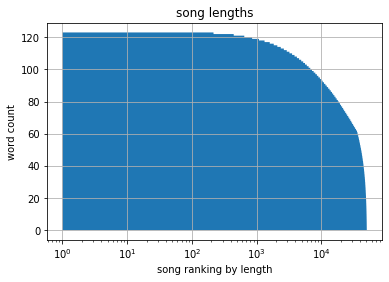

In [4]:
plt.fill_between(range(1, df.shape[0] + 1), 0, song_lengths.sort_values()[::-1].reset_index(drop=True))
plt.title("song lengths")
plt.xlabel('song ranking by length')
plt.ylabel('word count')
plt.xscale('log')
plt.grid(axis='both')
plt.show()

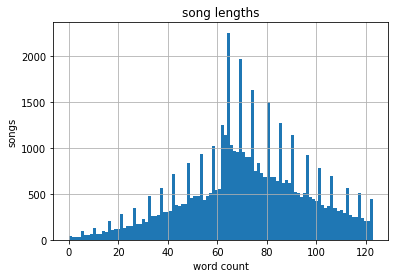

In [5]:
song_lengths.hist(bins=100)
plt.title("song lengths")
plt.xlabel('word count')
plt.ylabel('songs')
plt.show()

### Genres dataframe

In [6]:
unique_genres = []
for lst in df['genres'].tolist():
    for x in lst:
        if (x not in stop_words) and (not re.match('\-.*', x)) and (x not in unique_genres):
            unique_genres.append(x)
unique_genres.sort()

df_genres_full = pd.DataFrame(index=df.index, columns=unique_genres)
for genre in unique_genres:
    df_genres_full[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)
df_genres_full['band'] = df['band'].copy()
df_genres_bands = df_genres_full.groupby('band').max()
df_genres_full.drop('band', axis=1, inplace=True)
top_genres = df_genres_full.columns[df_genres_full.mean(axis=0) > 0.15]
df_genres = df_genres_full[top_genres].copy()

In [8]:
df_genres.sum(axis=0).sort_values(ascending=False)

death     16135
black     11460
thrash     9768
power      8660
heavy      8227
dtype: int64

## Tokenization & oversampling

### Train-test split lyrics and single genre label

In [10]:
# corpus_train, corpus_test, y_train, y_test = train_test_split(df['lyrics'].values, df_genres.values, test_size=0.2)

### Transform corpuses with vectorizer fit to training corpus

In [11]:
# vectorizer = CountVectorizer()
# vectorizer.fit(corpus_train)
# X_train = vectorizer.transform(corpus_train)
# X_test = vectorizer.transform(corpus_test)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40517, 147340) (10130, 147340) (40517, 5) (10130, 5)


In [12]:
def split_vectorize(texts, labels, test_size=0.2):
    corpus_train, corpus_test, y_train, y_test = train_test_split(texts, labels, test_size=test_size)
    vectorizer = CountVectorizer()
    vectorizer.fit(corpus_train)
    X_train = vectorizer.transform(corpus_train)
    X_test = vectorizer.transform(corpus_test)
    return X_train, X_test, y_train, y_test

### Cross-validation

In [13]:
def cross_validation(model, X, y, n_splits=3):
    out = {}
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    scores = np.zeros(n_splits)
    confusion_matrices = np.zeros((n_splits, 2, 2))
    for i, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
        X_fold_train, y_fold_train = X[train_idx], y[train_idx]
        X_fold_valid, y_fold_valid = X[valid_idx], y[valid_idx]
        model_ = clone(model)
        model_.fit(X_fold_train, y_fold_train)
        y_fold_pred = model_.predict(X_fold_valid)
        out[i] = [y_fold_valid, y_fold_pred]
    return out

In [14]:
def cross_validate_pipeline(classifier, genre, oversampler, n_splits=5):
    X_train, X_test, y_train, y_test = split_vectorize(df['lyrics'].values, df_genres[genre].values)
    pipeline = Pipeline(
        [
            ('oversampler', oversampler(random_state=0)),
            ('classifier', classifier)
        ]
    )
    results = cross_validation(pipeline, X_train, y_train, n_splits)
    return results

# Multi-label classification tools

**Binary relevance** is one method of classifying multiple labels at once. A binary relevance model trains a classifier for each label, making it a one-vs-all approach.

In [15]:
class BinaryRelevance:
    def __init__(self, estimator=None, estimators=[]):
        if estimator:
            self.estimator = estimator
            self.estimators_ = {}
        elif estimators:
            self.estimators_ = dict(estimators)

    def fit(self, X, y):
        estimators = {}
        for i in range(y.shape[1]):
            print('training binary classifier for label: {}'.format(i))
            estimator = deepcopy(self.estimator)
            estimator.fit(X, y[:, i])
            estimators[i] = estimator
        self.estimators_ = estimators

    def predict(self, X):
        y = np.zeros((X.shape[0], len(self.estimators_)))
        for i, estimator in self.estimators_.items():
            y[:, i] = estimator.predict(X)
        return y

Multi-label classification results need metrics designed for multi-label output. See [this stackexchange discussion](https://stats.stackexchange.com/questions/12702/what-are-the-measure-for-accuracy-of-multilabel-data) for more about these metrics.

In [16]:
class MultiLabelClassification:

    def __init__(self, y_true, y_pred=None, y_pred_classes=None, labels=None, class_thresh=0.5):
        self.true = y_true
        if y_pred_classes is None and y_pred is not None:
            self.pred = y_pred
            y_pred_classes = np.zeros_like(self.pred, dtype=int)
            y_pred_classes[self.pred > class_thresh] = 1
        else:
            self.pred = None
        self.pred_classes = y_pred_classes
        self.n_samples, self.n_labels = y_true.shape
        if labels is not None:
            if len(labels) == self.n_labels:
                self.labels = np.array(labels)
            else:
                raise ValueError("length of labels and shape of y_true do not match")
        else:
            self.labels = np.arange(self.true.shape[1])

    @property
    def __intersection(self):
        return self.true * self.pred_classes

    @property
    def __union(self):
        return np.minimum(1, self.true + self.pred_classes)

    @property
    def accuracy_score(self):
        # Number of labels in common / overall labels (true and predicted)
        return np.nanmean(self.__intersection.sum(1) / self.__union.sum(1))

    @property
    def precision_score(self):
        # Proportion of predicted labels that are correct
        return np.nanmean(self.__intersection.sum(1) / self.pred_classes.sum(1))

    @property
    def recall_score(self):
        # Proportion of true labels that were predicted
        return np.nanmean(self.__intersection.sum(1) / self.true.sum(1))

    @property
    def f1_score(self):
        # Harmonic mean of precision_score and recall_score
        p = self.precision_score
        r = self.recall_score
        return 2 * (p * r) / (p + r)

    def confusion_matrix(self, label=None, label_idx=None):
        confusion_matrices = multilabel_confusion_matrix(self.true, self.pred_classes)
        if label is not None:
            return confusion_matrices[np.where(self.labels == label)[0][0]]
        elif label_idx is not None:
            return confusion_matrices[label_idx]
        else:
            return confusion_matrices

    def print_report(self, verbose=0):
        print("Multi-label classification report")
        print("Accuracy:   {:.2f}".format(self.accuracy_score))
        print("Precision:  {:.2f}".format(self.precision_score))
        print("Recall:     {:.2f}".format(self.recall_score))
        print("F1-score:   {:.2f}".format(self.f1_score))
        if verbose == 1:
            for label, matrix in zip(self.labels, self.confusion_matrix()):
                print("===\nLabel: {}".format(label))
                print(matrix)

In [86]:
def cross_validate_multilabel(X, y, estimator, feature_names=None, evaluation_metric=balanced_accuracy_score, n_splits=5, verbose=False):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    y_prob, y_valid = np.zeros(y.shape), np.zeros(y.shape)
    if feature_names is None:
        feature_names = [str(x) for x in range(y.shape[1])]
    for i, feature in enumerate(feature_names):
        if verbose:
            print("training on feature '{}'".format(feature))
        scores = np.zeros(n_splits)
        confusion_matrices = np.zeros((n_splits, 2, 2))
        for j, (train_idx, valid_idx) in enumerate(kfold.split(X, y[:, i])):
            if verbose:
                print("fold {}/{}".format(j + 1, n_splits))
            X_fold_train, y_fold_train = X[train_idx], y[train_idx, i]
            X_fold_valid, y_fold_valid = X[valid_idx], y[valid_idx, i]
            estimator_ = deepcopy(estimator)
            estimator_.fit(X_fold_train, y_fold_train)
            try:
                y_fold_prob = estimator_.predict_proba(X_fold_valid)[:, 1]
            except AttributeError:
                y_fold_prob = estimator_.predict(X_fold_valid).reshape(-1)
            y_prob[valid_idx, i] = y_fold_prob
            y_valid[valid_idx, i] = y_fold_valid
            y_fold_pred = y_fold_prob.round()
            scores[j] = evaluation_metric(y_fold_valid, y_fold_pred)
            confusion_matrices[j] = confusion_matrix(y_fold_valid, y_fold_pred)
        if verbose:
            print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
            print("Average confusion matrix:")
            print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)
    return MultiLabelClassification(y_valid, y_prob)

In [134]:
def plot_roc_curve(true, prob, labels):
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(true[:, i], prob[:, i])
        plt.step(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.gca().set_aspect('equal')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("ROC curve", size=20)
    plt.xlabel("False positive rate", size=16)
    plt.ylabel("True positive rate", size=16)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(alpha=0.5)
    plt.show()

# Random forest classifier

### Single-genre classification

In [14]:
rf_params = dict(
    n_estimators=100,
    max_depth=30,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    n_jobs=-1,
    random_state=0
)
random_forest = RandomForestClassifier(**rf_params)
results = {}
for i, genre in enumerate(top_genres):
    results[genre] = cross_validate_pipeline(random_forest, 'black', n_splits=5)

In [17]:
for genre, folds in results.items():
    print(genre)
    scores = np.zeros(n_splits)
    confusion_matrices = np.zeros((n_splits, 2, 2))
    for k, v in folds.items():
        y_fold_valid, y_fold_pred = v
        scores[k] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
        confusion_matrices[k] = confusion_matrix(y_fold_valid, y_fold_pred)
    print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
    print("Average confusion matrix:")
    print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)

black
CV score: 72.56% +/- 0.73%
Average confusion matrix:
[[0.5930597  0.1815781 ]
 [0.07083446 0.15452773]]
death
CV score: 72.72% +/- 1.09%
Average confusion matrix:
[[0.5963176  0.17876447]
 [0.07085915 0.15405879]]
heavy
CV score: 72.46% +/- 1.12%
Average confusion matrix:
[[0.59108522 0.18155342]
 [0.0718217  0.15553965]]
power
CV score: 72.55% +/- 0.39%
Average confusion matrix:
[[0.59054224 0.18251598]
 [0.07103191 0.15590986]]
thrash
CV score: 72.92% +/- 1.20%
Average confusion matrix:
[[0.59700866 0.17780191]
 [0.0702668  0.15492263]]


### Multi-genre classification

In [74]:
X_train, X_test, y_train, y_test = train_test_split(df.lyrics.values, df_genres.values[:, 0])
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('randomforest', RandomForestClassifier(**rf_params))
    ]
)
pipeline.fit(X_train, y_train)

In [87]:
rf_params = dict(
    n_estimators=100,
    max_depth=30,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    n_jobs=-1,
    random_state=0
)
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('randomforest', RandomForestClassifier(**rf_params))
    ]
)

mlc = cross_validate_multilabel(df.lyrics.values, df_genres.values, pipeline, feature_names=df_genres.columns, n_splits=3, verbose=True)
mlc.print_report()

training on feature 'black'
fold 1/3
fold 2/3
fold 3/3
CV score: 72.69% +/- 0.65%
Average confusion matrix:
[[0.59221672 0.18151124]
 [0.07050763 0.15576441]]
training on feature 'death'
fold 1/3
fold 2/3
fold 3/3
CV score: 69.68% +/- 0.70%
Average confusion matrix:
[[0.53750469 0.1439177 ]
 [0.12593046 0.19264715]]
training on feature 'heavy'
fold 1/3
fold 2/3
fold 3/3
CV score: 70.66% +/- 0.20%
Average confusion matrix:
[[0.69478942 0.14277252]
 [0.06762493 0.09481312]]
training on feature 'power'
fold 1/3
fold 2/3
fold 3/3
CV score: 72.96% +/- 0.08%
Average confusion matrix:
[[0.69660592 0.13240666]
 [0.06515687 0.10583055]]
training on feature 'thrash'
fold 1/3
fold 2/3
fold 3/3
CV score: 67.06% +/- 0.91%
Average confusion matrix:
[[0.67129346 0.1358422 ]
 [0.09459593 0.09826841]]
Multi-label classification report
Accuracy:   0.40
Precision:  0.48
Recall:     0.63
F1-score:   0.55


D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


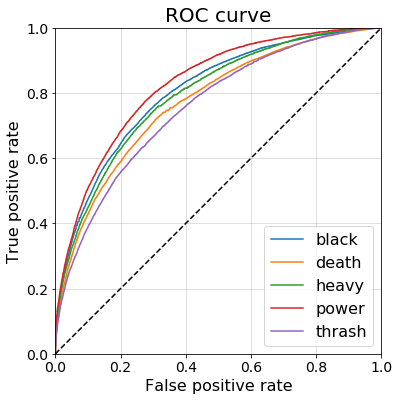

In [135]:
plot_roc_curve(mlc.true, mlc.pred, df_genres.columns)

## Logistic regression

training on feature 'black'
fold 1/5
fold 2/5
fold 3/5
fold 4/5
fold 5/5
CV score: 74.92% +/- 0.76%
Average confusion matrix:
[[0.66238869 0.11133927]
 [0.08093273 0.14533931]]
training on feature 'death'
fold 1/5
fold 2/5
fold 3/5
fold 4/5
fold 5/5
CV score: 70.25% +/- 0.90%
Average confusion matrix:
[[0.53872885 0.14269355]
 [0.12283057 0.19574703]]
training on feature 'heavy'
fold 1/5
fold 2/5
fold 3/5
fold 4/5
fold 5/5
CV score: 71.59% +/- 1.02%
Average confusion matrix:
[[0.73196833 0.10559362]
 [0.07183051 0.09060754]]
training on feature 'power'
fold 1/5
fold 2/5
fold 3/5
fold 4/5
fold 5/5
CV score: 73.40% +/- 1.37%
Average confusion matrix:
[[0.723261   0.10575157]
 [0.069165   0.10182242]]
training on feature 'thrash'
fold 1/5
fold 2/5
fold 3/5
fold 4/5
fold 5/5
CV score: 66.97% +/- 0.65%
Average confusion matrix:
[[0.67642703 0.13070863]
 [0.09615574 0.09670859]]
Multi-label classification report
Accuracy:   0.44
Precision:  0.54
Recall:     0.61
F1-score:   0.57


D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


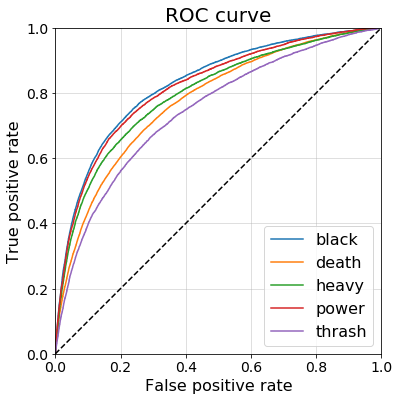

In [138]:
lr_params = dict(
    solver='lbfgs',
    max_iter=1000,
    random_state=0
)
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('randomforest', LogisticRegression(**lr_params))
    ]
)

mlc = cross_validate_multilabel(df.lyrics.values, df_genres.values, pipeline, feature_names=df_genres.columns, verbose=True)
mlc.print_report()
plot_roc_curve(mlc.true, mlc.pred, df_genres.columns)

# Stacked model

In [143]:
class StackedModel(BaseEstimator, TransformerMixin):
    def __init__(self, clfs=[], meta_clf=None):
        self.clfs = clfs
        self.meta_clf = meta_clf

    def fit(self, X, y, split_test_size=0.2):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size)
        y_prob = np.zeros((X_test.shape[0], len(self.clfs)))
        for j, clf in enumerate(self.clfs):
            clf.fit(X_train, y_train)
            y_prob[:, j] = clf.predict_proba(X_test)[:, 1]
        self.meta_clf.fit(y_prob, y_test)
        return self

    def predict_base(self, X):
        y_prob = np.zeros((X.shape[0], len(self.clfs)))
        for j, clf in enumerate(self.clfs):
            y_prob[:, j] = clf.predict_proba(X)[:, 1]
        return y_prob

    def predict(self, X):
        return self.meta_clf.predict(self.predict_base(X))

    def predict_proba(self, X):
        return self.meta_clf.predict_proba(self.predict_base(X))


training on feature 'black'
fold 1/3
fold 2/3
fold 3/3
CV score: 72.23% +/- 1.12%
Average confusion matrix:
[[0.61806227 0.15566569]
 [0.08016269 0.14610935]]
training on feature 'death'
fold 1/3
fold 2/3
fold 3/3
CV score: 69.36% +/- 0.69%
Average confusion matrix:
[[0.53890655 0.14251584]
 [0.12859597 0.18998164]]
training on feature 'heavy'
fold 1/3
fold 2/3
fold 3/3
CV score: 69.78% +/- 0.43%
Average confusion matrix:
[[0.71192766 0.12563429]
 [0.07380496 0.08863309]]
training on feature 'power'
fold 1/3
fold 2/3
fold 3/3
CV score: 71.81% +/- 0.53%
Average confusion matrix:
[[0.71496831 0.11404427]
 [0.07289672 0.09809071]]
training on feature 'thrash'
fold 1/3
fold 2/3
fold 3/3
CV score: 66.29% +/- 0.48%
Average confusion matrix:
[[0.6796059  0.12752976]
 [0.09957154 0.09329279]]
Multi-label classification report
Accuracy:   0.40
Precision:  0.49
Recall:     0.60
F1-score:   0.54


D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


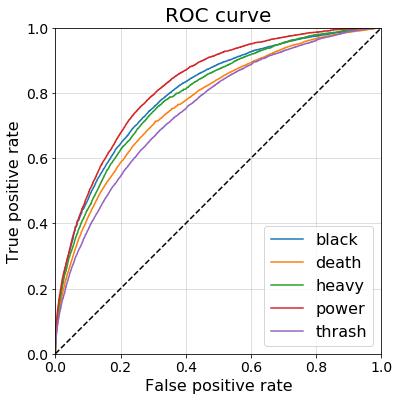

In [144]:
rf_params = dict(
    n_estimators=100,
    max_depth=30,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    n_jobs=-1,
    random_state=0
)
lr_params = dict(
    solver='lbfgs',
    max_iter=1000,
    random_state=0
)
stacked_model = StackedModel(
    [
        RandomForestClassifier(**rf_params)
    ],
    LogisticRegression(**lr_params)
)
n_splits = 5

pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('stackedmodel', stacked_model)
    ]
)
results = cross_validation(pipeline, X_train, y_train, n_splits)
mlc = cross_validate_multilabel(df.lyrics.values, df_genres.values, pipeline, feature_names=df_genres.columns, n_splits=3, verbose=True)
mlc.print_report()
plot_roc_curve(mlc.true, mlc.pred, df_genres.columns)

# Test with Keras model

In [8]:
def nn_model(input_dim):
    model = Sequential()
    model.add(layers.Dense(40, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model

def nn_batch_generator(X_data, y_data, batch_size):
    number_of_batches = X_data.shape[0] // batch_size
    counter = 0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X_data[index_batch, :].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch), y_batch
        if (counter > number_of_batches):
            counter = 0

In [24]:
epochs = 5
batch_size = 128
# feature_reducer = FeatureReducer(0)
oversampler = SMOTE(random_state=0)

n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
y_pred, y_valid = np.zeros(y_train.shape), np.zeros(y_train.shape)
for i, genre in enumerate(top_genres):
    print(genre)
    scores = np.zeros(n_splits)
    confusion_matrices = np.zeros((n_splits, 2, 2))
    for j, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train[:, i])):
        X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx, i]
        X_fold_valid, y_fold_valid = X_train[valid_idx], y_train[valid_idx, i]
#         feature_reducer.fit(X_fold_train)
#         X_fold_train = feature_reducer.transform(X_fold_train)
#         X_fold_valid = feature_reducer.transform(X_fold_valid)
        X_fold_train, y_fold_train = oversampler.fit_resample(X_fold_train, y_fold_train)
        keras_model = KerasClassifier(
            nn_model,
            input_dim=X_fold_train.shape[1],
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.01, patience=0)],
            validation_data=(X_fold_valid, y_fold_valid)
        )
        keras_model.fit(X_fold_train, y_fold_train)
        y_fold_pred = keras_model.predict(X_fold_valid).reshape(-1)
        y_pred[valid_idx, i] = y_fold_pred
        y_valid[valid_idx, i] = y_fold_valid
        scores[j] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
        confusion_matrices[j] = confusion_matrix(y_fold_valid, y_fold_pred)
    print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
    print("Average confusion matrix:")
    print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)
mlc = MultiLabelClassification(y_pred, y_valid)
mlc.print_report()

black
Train on 50164 samples, validate on 8104 samples
Epoch 1/5
50164/50164 [==============================] - 81s 2ms/step - loss: 0.3786 - binary_accuracy: 0.8555 - val_loss: 0.4257 - val_binary_accuracy: 0.8166 7s - 
Epoch 2/5
50164/50164 [==============================] - 79s 2ms/step - loss: 0.1697 - binary_accuracy: 0.9366 - val_loss: 0.4938 - val_binary_accuracy: 0.8108
Train on 50164 samples, validate on 8104 samples
Epoch 1/5
50164/50164 [==============================] - 80s 2ms/step - loss: 0.3777 - binary_accuracy: 0.8572 - val_loss: 0.4198 - val_binary_accuracy: 0.8206
Epoch 2/5
50164/50164 [==============================] - 80s 2ms/step - loss: 0.1739 - binary_accuracy: 0.9354 - val_loss: 0.4738 - val_binary_accuracy: 0.8214
Train on 50164 samples, validate on 8104 samples
Epoch 1/5
50164/50164 [==============================] - 82s 2ms/step - loss: 0.3773 - binary_accuracy: 0.8581 - val_loss: 0.4211 - val_binary_accuracy: 0.8168
Epoch 2/5
50164/50164 [==================

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


## Stacking RF with NN

In [159]:
feature_reducer = FeatureReducer(0)
oversampler = RandomOverSampler(random_state=0)
rf_params = dict(
    n_estimators=100,
    max_depth=30,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    n_jobs=-1,
    random_state=0
)
random_forest = RandomForestClassifier(**rf_params)
nn_params = dict(
    epochs=1,
    batch_size=128
)
keras_nn = KerasClassifier(nn_model, input_dim=X_train.shape[1], **nn_params)
lr_params = dict(
    random_state=0
)
logistic_regression = LogisticRegression(**lr_params)
stacked_model = StackedModel([random_forest, keras_nn], logistic_regression)
n_splits = 5

pipeline = Pipeline(
    [
#         ('featurereducer', feature_reducer),
        ('oversampler', oversampler),
        ('stackedmodel', stacked_model)
    ]
)
results = cross_validation(pipeline, X_train, y_train, n_splits)

Epoch 1/1
36380/36380 [==============================] - 61s 2ms/step - loss: 0.3912 - binary_accuracy: 0.8296


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Epoch 1/1
36380/36380 [==============================] - 61s 2ms/step - loss: 0.4036 - binary_accuracy: 0.8233


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Epoch 1/1
36380/36380 [==============================] - 61s 2ms/step - loss: 0.4031 - binary_accuracy: 0.8275


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Epoch 1/1
36382/36382 [==============================] - 66s 2ms/step - loss: 0.3995 - binary_accuracy: 0.8255


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Epoch 1/1
36382/36382 [==============================] - 63s 2ms/step - loss: 0.3920 - binary_accuracy: 0.8311


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [160]:
scores = np.zeros(n_splits)
confusion_matrices = np.zeros((n_splits, 2, 2))
for k, v in results.items():
    y_fold_valid, y_fold_pred = v
    scores[k] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
    confusion_matrices[k] = confusion_matrix(y_fold_valid, y_fold_pred)
print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)

CV score: 71.72% +/- 1.04%
Average confusion matrix:
[[0.74258125 0.09417687]
 [0.07395195 0.08928992]]


In [33]:
feature_reducer = FeatureReducer(0)
oversampler = RandomOverSampler(random_state=0)
rf_params = dict(
    n_estimators=100,
    max_depth=30,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    n_jobs=-1,
    random_state=0
)
nn_params = dict(
    epochs=1,
    batch_size=128
)
lr_params = dict(
    random_state=0
)
n_splits = 3

kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
scores = np.zeros(n_splits)
confusion_matrices = np.zeros((n_splits, 2, 2))

for i, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
    X_fold_valid, y_fold_valid = X_train[valid_idx], y_train[valid_idx]
    feature_reducer.fit(X_fold_train)
    X_fold_train = feature_reducer.transform(X_fold_train)
    X_fold_valid = feature_reducer.transform(X_fold_valid)
    X_fold_train, y_fold_train = oversampler.fit_resample(X_fold_train, y_fold_train)

    rf_model = RandomForestClassifier(**rf_params)
    keras_model = KerasClassifier(nn_model, input_dim=X_fold_train.shape[1], **nn_params)
    lr_model = LogisticRegression(**lr_params)
    clfs = [rf_model, keras_model]
    meta_clf = lr_model

    stacked_model = StackedModel([rf_model, keras_model], lr_model)
    stacked_model.fit(X_fold_train, y_fold_train)
    y_fold_pred = stacked_model.predict(X_fold_valid)

    scores[i] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
    confusion_matrices[i] = confusion_matrix(y_fold_valid, y_fold_pred)

print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)

Epoch 1/1
30316/30316 [==============================] - 5s 149us/step - loss: 0.4279 - binary_accuracy: 0.8083


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Epoch 1/1
30318/30318 [==============================] - 5s 155us/step - loss: 0.4212 - binary_accuracy: 0.8162


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Epoch 1/1
30318/30318 [==============================] - 5s 154us/step - loss: 0.4244 - binary_accuracy: 0.8134


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CV score: 71.28% +/- 1.62%
Average confusion matrix:
[[0.75691828 0.07983985]
 [0.07819124 0.08505064]]
